In [ ]:
# https://github.com/mashaan14/YouTube-channel/blob/main/notebooks/2023_12_04_GCN_introduction.ipynb

In [2]:
# Standard libraries
import math
import time
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.utils import to_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.transforms import RandomNodeSplit

In [4]:
num_nodes_per_class = 100
num_nodes = [num_nodes_per_class] * 3
edge_probs = [[0.1, 0.05, 0.02],
              [0.05, 0.1, 0.02],
              [0.02, 0.02, 0.1]]
dataset = StochasticBlockModelDataset('./gcn_data', num_nodes, edge_probs, num_channels=10)

Processing...
Done!


In [5]:
colors = cm.tab10.colors
y_colors = np.array(colors)[dataset[0].y.numpy()]

In [6]:
dataset[0]

Data(x=[300, 10], edge_index=[2, 4678], y=[300])

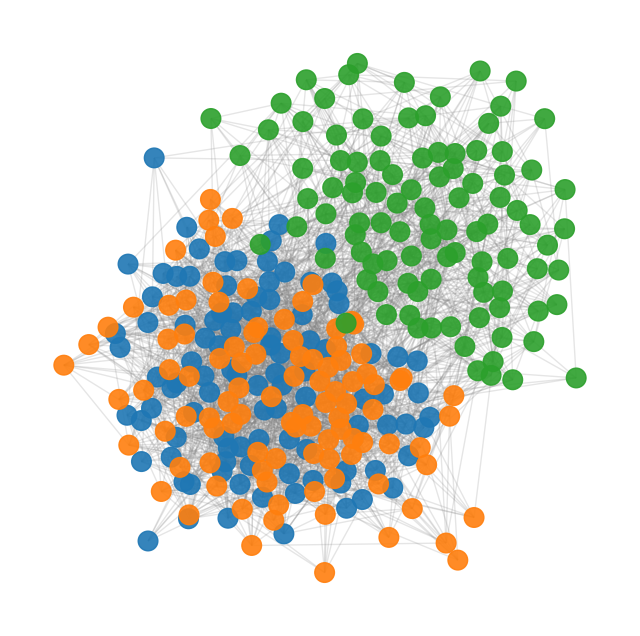

In [7]:

G = to_networkx(dataset[0], to_undirected=True)
node_pos=nx.spring_layout(G, seed=0)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G,
                pos=node_pos,
                node_size=200,
                node_color=y_colors,
                alpha=0.9
                )
nx.draw_networkx_edges(G,
                pos=node_pos,
                edge_color="grey",
                alpha=0.2
                )
plt.show()

In [11]:
split = RandomNodeSplit(num_val=0.1, num_test=0.1)
data = split(dataset[0])
data

Data(x=[300, 10], edge_index=[2, 4678], y=[300], train_mask=[300], val_mask=[300], test_mask=[300])

In [8]:
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [9]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid) # nfeat = 10, nhid = 3
        self.gc2 = GraphConvolution(nhid, nclass) # nhid = 3, nclass = 3
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [12]:
adj = to_dense_adj(data.edge_index)[0]

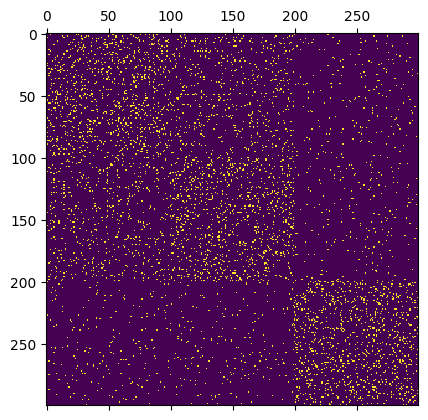

In [16]:
plt.matshow(adj)
plt.show()

In [17]:
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

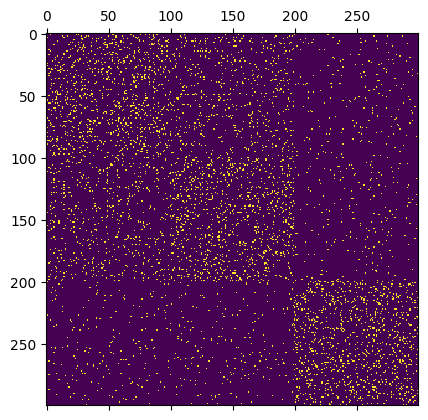

In [18]:
plt.matshow(adj)
plt.show()

In [ ]:
# normalized adjacency

adj = to_dense_adj(data.edge_index)[0]
# symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
adj = adj + torch.eye(adj.shape[0])
# degree matrix
d = np.zeros((adj.shape[0],adj.shape[0]))
np.fill_diagonal(d, adj.sum(1).numpy())
d = torch.from_numpy(d)
d_inv_sqrt = torch.pow(d, -0.5)
# set inf values to zero
d_inv_sqrt = torch.nan_to_num(d_inv_sqrt, posinf=0.0)
d_inv_sqrt = d_inv_sqrt.to(dtype=torch.float32)

adj = (d_inv_sqrt @ adj) @ d_inv_sqrt